<h2> Assessing Loan Quality: Developing Machine Learning Models for Loan Default Classification and Profit Optimization in Lending Club </h2>
<b> Ben Wynia </b>

This project aimed to use machine learning models to evaluate the quality of loan applications received by the LendingClub. The LendingClub is the largest peer-to-peer lending platform in the world, and it provides a marketplace for borrowers to obtain personal and business loans from individual investors. The primary objective of this analysis was to develop a model that could accurately classify loan applicants into those likely to "pay off" or "charge off" (default) on their loan.

To achieve this goal, the team used a dataset that contained a range of financial indicators across major categories such as debt, income, credit history, charge-offs, and others. Using this data, the team trained a machine learning model to classify loan applicants based on their likelihood of defaulting on their loan. In addition to classification, the team also aimed to optimize the acceptance point to maximize the average profit per applicant.

The outcome of this project has implications for both lenders and borrowers. By accurately predicting the likelihood of default, lenders can make more informed decisions about whether to approve a loan application. On the other hand, borrowers can benefit from a better understanding of the factors that influence their creditworthiness, which can help them make more informed financial decisions in the future. Overall, this project demonstrates the value of machine learning in the lending industry and highlights the potential benefits of using data-driven approaches to improve lending practices.

<h2> Section 1: Import Libraries </h2>

In [1]:
# Base python libraries
import datetime
import os
import logging
import time
import os
import openai
import json
import pandas as pd
import requests
import json
import re
import copy
import math
from dataclasses import dataclass

# Pandas!
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# Numerical Python!
import numpy as np

# Scientific Python!
from scipy.stats import jarque_bera

# sklearn libraries
import sklearn.tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import sklearn.ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE

# Visualization Libraries
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical models 
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Image processing
from IPython.display import Image
from io import BytesIO

# PDF processing
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib import colors, units
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image,  Table, TableStyle, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER, TA_JUSTIFY
import markdown2
from reportlab.platypus import Paragraph as ReportLabParagraph
from reportlab.lib.styles import ParagraphStyle as ReportLabParagraphStyle
from html import escape
from xml.sax.saxutils import unescape

# Other/random
import itertools
from functools import partial
import pickle
from PIL import Image

# Suppress
import warnings

# suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# import proprietary functions
pd.options.mode.chained_assignment = None
from lib import descriptives
from lib import data_cleanup
from lib import histograms
from lib import corr_map
from lib import train_test_validate
from lib import hyperparameters
from lib import analyze_classification_model
from lib import model_pdf_report

<h2> Section 2: Import Datasets </h2>

In [2]:
current_directory = os.getcwd()
data_dictionary = pd.read_csv(f"{current_directory}/data/data_dictionary.csv")
data_dictionary.columns = ['Name', 'Definition']
df = pd.read_csv(f"{current_directory}/data/loan_data.gzip", low_memory=False)

In [3]:
data_dictionary

,Name,Definition
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
148,settlement_amount,The loan amount that the borrower has agreed t...
149,settlement_percentage,The settlement amount as a percentage of the p...
150,settlement_term,The number of months that the borrower will be...
151,NaN,NaN


<h2> Section 3. Data Cleanup and Exploratory Data Analysis</h2>

To preprocess the data, it is important to perform data cleaning to ensure that the data is consistent and accurate. This involves removing duplicates, correcting errors, and handling missing or invalid values. Feature engineering is also an important preprocessing step, as it can improve the performance of the machine learning model by creating new features that capture the underlying patterns in the data. Feature engineering techniques such as normalization, scaling, and transformation can be applied to the data to ensure that the features are on a similar scale and have similar ranges.

Handling missing values or outliers is another important preprocessing step. Missing values can be imputed using techniques such as mean imputation, regression imputation, or k-nearest neighbors imputation. Outliers can be detected using statistical methods such as z-score analysis or the interquartile range (IQR) method, and can be removed or replaced with a more appropriate value. It is important to keep in mind that preprocessing steps can have a significant impact on the performance of the machine learning model, and therefore it is important to carefully evaluate the impact of each step and to select the best preprocessing pipeline.

<h3>Data Cleanup Functions</h3>
<b>Function 1: Select Columns</b>

This function processes a dataframe and retains only the selected columns. It returns a new dataframe containing only the selected columns.

<b>Parameters:</b>

df: Pandas DataFrame
Input data frame from which columns are to be retained.
columns_to_keep: list
List of column names to be retained in the input data frame.
<b>Output:</b>

A new data frame containing only the selected columns.
<p></p>
<b>Function 2: Get Dataframe Shape</b>

This function provides information about the size and shape of the input dataframe.

<b>Parameters:</b>

df: Pandas DataFrame
Input data frame for which information is to be provided.
<b>Output:</b>

A string describing the shape of the input dataframe.
<p></p>
<b>Function 3: Clean Up Missing Data</b>

This function drops any columns from the input dataframe that are missing too many data points based on a breakpoint provided by the user. It returns a new data frame with the columns with too many missing values removed.

<b>Parameters:</b>

df: Pandas DataFrame
Input data frame from which columns with too many missing values are to be removed.
breakpoint: float
The breakpoint for the minimum data completeness required for each column.
<b>Output:</b>

A tuple containing the nan_percentages by variable and the resulting data frame with the columns with too many missing values removed.
<p></p>
<b>Function 4: Drop Rows with NA</b>

This function drops NA records from the input dataframe. It returns a new data frame without NA records.

<b>Parameters:</b>

df: Pandas DataFrame
Input data frame from which NA rows are to be removed.
<b>Output:</b>

A new data frame without NA records.
<p></p>
<b>Function 5: One-Hot Encode Categorical Variables</b>

This function creates a dummy binary variable for each level of the categorical variable in the input dataframe. Columns are named with the prefix of '1h_<original column name>', and the original variable is dropped from the input data frame.

<b>Parameters:</b>

<p> df: Pandas DataFrame -- Input data frame in which categorical variables are to be one-hot encoded.</p>
<p> col_list: List of column names of the categorical variables to be one-hot encoded.</p>
    
<b>Output:</b>

A new data frame with all variables in col_list recoded.

<p></p>
<b>Function 6: Run Data Cleanup Functions</b>

This function prunes the input dataframe to only keep the selected columns, removes columns with too many missing records, removes rows with missing values, recodes the categorical variables into dummies, prunes the data dictionary to retain only the variables use in the function, and prints the resulting data frame shape after each operation so you know how the data frame has changed.

<b>Parameters:</b>

df: Pandas DataFrame
<p>Input data frame for cleanup.</p>
<p>data_dictionary: Pandas DataFrame -- Data dictionary which has two columns "Name" and "Definition".</p>
<p>columns_to_keep: list -- List of column names to be retained in the input data frame.</p>
<p>columns_to_recode: list -- List of column names of the categorical variables to be one-hot encoded.</p>
<p>breakpoint: float --The breakpoint for the minimum data completeness required for each column.</p>
<b>Output:</b>

A tuple containing the resulting data frame and data dictionary.
<p><b>Required Libraries:</b></p>

pandas
numpy
matplotlib.pyplot
seaborn

In [4]:
data_cleanup.get_dataframe_shape(df)

The dataset has 142 columns and 88876 rows


Original dataframe---
The dataset has 142 columns and 88876 rows


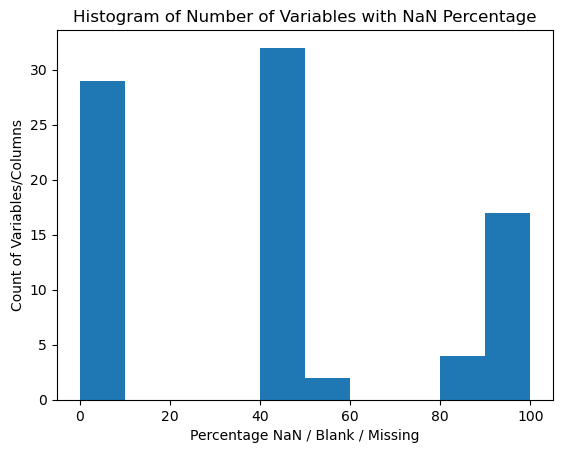

After cleaning up columns with missing data---
The dataset has 28 columns and 88876 rows
Number of rows before filtering: 88876
Number of rows after filtering: 84232
Percentage of rows dropped: 5.23%
After cleaning up rows with missing data---
The dataset has 28 columns and 84232 rows
After recoding categorical variables into one-hot variables---
The dataset has 46 columns and 84232 rows


In [5]:
# Keep any columns that store information that appears to be "known" at the time an origination decision is made
columns_to_keep = ['loan_status','acc_open_past_24mths', 'all_util', 'annual_inc', 'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'desc', 'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'home_ownership', 'il_util', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'last_fico_range_high', 'last_fico_range_low', 'max_bal_bc', 'member_id', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_act_il', 'open_rv_12m', 'open_rv_24m', 'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'term', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bal_il', 'total_bc_limit', 'total_cu_tl', 'total_il_high_credit_limit', 'total_rev_hi_lim  ', 'verification_status', 'verified_status_joint', 'revol_bal_joint ', 'sec_app_fico_range_low ', 'sec_app_fico_range_high ', 'sec_app_earliest_cr_line ', 'sec_app_inq_last_6mths ', 'sec_app_mort_acc ', 'sec_app_open_acc ', 'sec_app_revol_util ', 'sec_app_open_act_il', 'sec_app_num_rev_accts ', 'sec_app_chargeoff_within_12_mths ', 'sec_app_collections_12_mths_ex_med ', 'sec_app_mths_since_last_major_derog']
columns_to_recode = ['home_ownership', 'verification_status', 'purpose']
breakpoint = 0.95
df, data_dictionary2 = data_cleanup.run_data_cleanup_functions(df, data_dictionary, columns_to_keep, columns_to_recode, breakpoint)

<h3> Descriptive Statistics </h3>
<b>Function: Descriptive Statistics </b>

This function takes a Pandas dataframe as input and computes various descriptive statistics of the variables. If the variable is numeric, it calculates the count, missing values, mean, median, mode, range, variance, standard deviation, skewness, kurtosis, minimum, maximum, and interquartile range. If the variable is not numeric, it calculates the frequency distribution, relative frequency, and mode.

<b>Parameters:</b>
df: Pandas DataFrame
Input data frame containing variables for which descriptive statistics are to be computed.

<b>Output:</b>
A Pandas DataFrame containing descriptive statistics for each variable in the input data frame.

<b> Required Libraries:</b>
pandas

<b>Example Usage:</b>

import pandas as pd
df = pd.DataFrame({'var1': [1,2,3,4,5], 'var2': ['a','b','c','d','e'], 'var3': [1.1,2.2,3.3,4.4,5.5]})
descriptive_statistics(df)

<b> Note: </b> The function assumes that the input dataframe is cleaned and has no missing values except for NaNs.

<b> Note on Data Types</b>
The function checks whether a variable is numeric or not based on its data type. It assumes that variables of type "int64" and "float64" are numeric and all other variables are not numeric. If you have variables that are numeric but have data types other than "int64" or "float64", you can modify the code to include those data types.

In [6]:
descriptives.descriptive_statistics(df)

,count,missing_values,data_type,freq_dist,rel_freq,mode
loan_status,84232,0,object,"{'Fully Paid': 70154, 'Charged Off': 12034, 'D...","{'Fully Paid': 83.28663690758856, 'Charged Off...",Fully Paid
annual_inc,84232,0,float64,None,None,60000.0
chargeoff_within_12_mths,84232,0,float64,None,None,0.0
collections_12_mths_ex_med,84232,0,float64,None,None,0.0
delinq_2yrs,84232,0,float64,None,None,0.0
delinq_amnt,84232,0,float64,None,None,0.0
dti,84232,0,float64,None,None,0.0
earliest_cr_line,84232,0,object,"{'Oct-1999': 706, 'Oct-2000': 688, 'Nov-1998':...","{'Oct-1999': 0.8381612688764365, 'Oct-2000': 0...",Oct-1999
emp_length,84232,0,object,"{'10+ years': 25100, '2 years': 8403, '< 1 yea...","{'10+ years': 29.798651343907306, '2 years': 9...",10+ years
fico_range_high,84232,0,float64,None,None,684.0


<h3>Variable Histograms</h3>
<b>Function: Create Histogram</b>

This function creates a matrix of histograms for all numeric columns of the input dataframe. It calculates the optimal set of rows and columns for the histogram matrix based on the number of numeric columns in the dataframe. It uses the Seaborn library to plot histograms of each numeric variable in the dataframe.

<b>Parameters:</b>

df: Pandas DataFrame
Input data frame containing numeric variables for which histograms are to be plotted.
figsize: tuple, default=(15, 15)
The figure size of the histogram matrix.
bins: int, default=20
The number of bins to use for the histogram.
color: str, default='steelblue'
The color of the bars in the histogram.
<b>Output:</b>

Displays a matrix of histograms for all numeric columns of the input dataframe.
<b>Required Libraries:</b>

numpy
matplotlib.pyplot
seaborn
<p> <b>Example Usage:</b> </p>

python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.DataFrame({'var1': [1,2,3,4,5], 'var2': [2,4,6,8,10], 'var3': [3,6,9,12,15], 'var4': [4,8,12,16,20]})
create_histogram(df)

<b> Note: </b> The function assumes that the input dataframe only contains numeric columns.

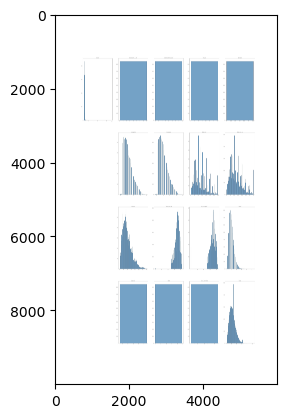

In [7]:
if os.path.isfile('histograms.jpg'):
    img = plt.imread('histograms.jpg')
    plt.imshow(img)
    plt.show()
else:
    histograms.create_histogram(df, figsize=(60, 100))

<h3> Correlation Heatmap </h3>
    
<b>Function: Correlation Heatmap </b>
This function computes and visualizes pairwise correlation matrix of numeric variables in a Pandas dataframe using Spearman's rank correlation method. It drops variables that have too few samples or zero variance before computing the correlation matrix. It creates a heatmap of the correlation matrix using Seaborn library and saves the plot as an image file.

<b>Parameters:</b>
df: Pandas DataFrame
Input data frame containing numeric variables for which correlation heatmap is to be plotted.
Output:
A heatmap of pairwise correlations between numeric variables in the input data frame.

<b> Required Libraries:</b>
numpy
seaborn
pingouin
matplotlib.pyplot

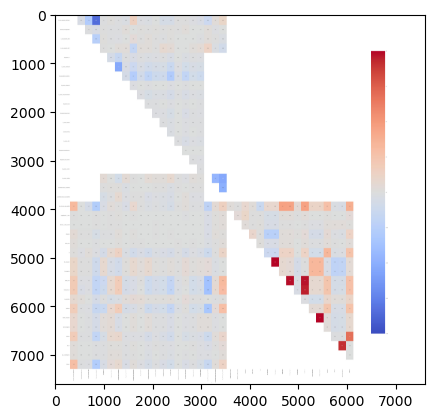

In [8]:
try:
    if os.path.isfile('corr_plot.jpg'):
        img = plt.imread('corr_plot.jpg')
        plt.imshow(img)
        plt.show()
    else:
        corr_map.correlation_heatmap(df)
except:
    corr_map.correlation_heatmap(df)

<b> Flag Categorical and Ordinal Variables </b>

In [9]:
def identify_categorical_ordinal(df, threshold=10, include_ordinal=True):
    categorical_vars = []
    ordinal_vars = []
    
    for column in df.columns:
        unique_values = df[column].nunique()
        
        if unique_values <= threshold:
            categorical_vars.append(column)
            
            if include_ordinal:
                if df[column].dtype in ['int64', 'float64']:
                    sorted_unique_values = sorted(df[column].dropna().unique())
                    if all(sorted_unique_values[i] < sorted_unique_values[i+1] for i in range(len(sorted_unique_values)-1)):
                        ordinal_vars.append(column)
                        
    return categorical_vars, ordinal_vars

In [10]:
categorical_vars, ordinal_vars = identify_categorical_ordinal(df,10,False)

print("Categorical Variables:", categorical_vars)
print("Ordinal Variables:", ordinal_vars)

Categorical Variables: ['loan_status', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'out_prncp', 'out_prncp_inv', 'pub_rec_bankruptcies', 'term', '1h_home_ownership_MORTGAGE', '1h_home_ownership_OTHER', '1h_home_ownership_OWN', '1h_home_ownership_RENT', '1h_verification_status_Not Verified', '1h_verification_status_Source Verified', '1h_verification_status_Verified', '1h_purpose_car', '1h_purpose_credit_card', '1h_purpose_debt_consolidation', '1h_purpose_educational', '1h_purpose_home_improvement', '1h_purpose_house', '1h_purpose_major_purchase', '1h_purpose_medical', '1h_purpose_moving', '1h_purpose_other', '1h_purpose_renewable_energy', '1h_purpose_small_business', '1h_purpose_vacation', '1h_purpose_wedding']
Ordinal Variables: []


In [11]:
"""
Some of the variables are ordinal or strings and not categorical. 
These require manual handling, which is accomplished in the lines below
"""
# Create a dictionary to map emp_length categories to their corresponding numeric values
emp_length_dict = {'10+ years': 10,
                   '9 years': 9,
                   '8 years': 8,
                   '7 years': 7,
                   '6 years': 6,
                   '5 years': 5,
                   '4 years': 4,
                   '3 years': 3,
                   '2 years': 2,
                   '1 year': 1,
                   '< 1 year': 0.5,
                   np.nan: 0}

# Replace emp_length categories with their corresponding numeric values
df['emp_length'] = df['emp_length'].map(emp_length_dict)

# Clean up the interest rate field
df['int_rate'] = df['int_rate'].str.strip('%').astype(float) / 100

# Convert the earliest credit line date to a number of months relative to the newest record... or "months ago"
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')
fixed_point = df['earliest_cr_line'].max()
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: (fixed_point.year - x.year) * 12 + (fixed_point.month - x.month))

# Define a dictionary to map terms to the number of months
term_map = {
    ' 36 months': 36,
    ' 60 months': 60
}

# Map the terms to the number of months and store the result in a new column
df['term'] = df['term'].map(term_map)

# Use replace() and map() to refactor the values in the loan_status column into a binary "Fully Paid" or "Charged Off"
df['loan_status'] = df['loan_status'].replace({'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid', 'Does not meet the credit policy. Status:Charged Off': 'Charged Off'})
df['loan_status'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

# View new distribution of target (dependent) variable
df["loan_status"].value_counts()

1    71668
0    12564
Name: loan_status, dtype: int64

<b> Define the Dependent Variable </b> 

In [12]:
target = 'loan_status'
target 

'loan_status'

<b> Define the Independent Variables </b> 

In [13]:
features = [col for col in df.columns if col != target]
features

['annual_inc',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'funded_amnt_inv',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'last_fico_range_high',
 'last_fico_range_low',
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'pub_rec',
 'pub_rec_bankruptcies',
 'term',
 'total_acc',
 '1h_home_ownership_MORTGAGE',
 '1h_home_ownership_OTHER',
 '1h_home_ownership_OWN',
 '1h_home_ownership_RENT',
 '1h_verification_status_Not Verified',
 '1h_verification_status_Source Verified',
 '1h_verification_status_Verified',
 '1h_purpose_car',
 '1h_purpose_credit_card',
 '1h_purpose_debt_consolidation',
 '1h_purpose_educational',
 '1h_purpose_home_improvement',
 '1h_purpose_house',
 '1h_purpose_major_purchase',
 '1h_purpose_medical',
 '1h_purpose_moving',
 '1h_purpose_other',
 '1h_purpose_renewable_energy',
 '1h_purpose_small_business',
 '1h_purpose_vacation',

In [14]:
df[target].value_counts()

1    71668
0    12564
Name: loan_status, dtype: int64

<h3> View Independent Variable Correlations </h3>
<b>Function: View Independent Variable Correlations </b>

This function computes the Pearson correlation between the target variable and each independent variable in a Pandas dataframe, and returns the resulting correlation coefficients sorted in descending order.

<b>Parameters:</b>
data: Pandas DataFrame
Input data frame containing the target variable and independent variables to be used in the correlation analysis.

target_variable: str
Name of the target variable for which correlations with the independent variables are to be computed.

<b>Required Libraries:</b>
pandas

<b>Outputs:</b>
A Pandas series containing the correlation coefficients between the target variable and each independent variable, sorted in descending order.

In [15]:
def view_independent_variable_correlations(data, target_variable):
    correlations = data.corr(method='pearson')[target_variable].drop(target_variable)
    correlations = correlations.sort_values(ascending=False)
    return correlations

In [16]:
correlations = view_independent_variable_correlations(df, target)
correlations

last_fico_range_high                      0.466954
last_fico_range_low                       0.423546
fico_range_low                            0.118879
fico_range_high                           0.118879
1h_verification_status_Not Verified       0.046156
annual_inc                                0.045908
1h_purpose_credit_card                    0.036063
1h_home_ownership_MORTGAGE                0.032840
earliest_cr_line                          0.029779
1h_purpose_major_purchase                 0.019696
1h_purpose_car                            0.016661
1h_purpose_home_improvement               0.014360
1h_purpose_wedding                        0.013961
total_acc                                 0.013490
chargeoff_within_12_mths                  0.008411
1h_purpose_vacation                       0.000679
1h_home_ownership_OWN                    -0.001898
1h_purpose_renewable_energy              -0.002716
1h_purpose_moving                        -0.003772
1h_purpose_medical             

<h3> Compute Class Weights </h3>
<b>Function: Compute Class Weights </b>

This function computes the class weights for a binary classification problem. It takes a Pandas dataframe and calculates the proportion of samples in each class, then assigns a weight of 1 to the minority class and a weight proportional to the class imbalance to the majority class.

<b>Parameters:</b>
df: Pandas DataFrame
Input data frame containing the target variable for which class weights are to be computed.

<b>Outputs:</b>
A dictionary containing the class weights for the binary classification problem. The keys are the class labels (0 and 1) and the values are the corresponding weights.

<b>Example Usage:</b>
distribution = df['output'].value_counts()
low_weight = distribution[1]/distribution[0]
class_weights = compute_class_weights(df)
print(class_weights)

<b>Required Libraries:</b>
pandas

In [17]:
def compute_class_weights(df, target_variable):

    # Count the number of samples in each class
    distribution = df[target_variable].value_counts()

    # Compute the weight of the minority class relative to the majority class
    low_weight = distribution[1] / distribution[0]

    # Assign weights to each class
    class_weights = {0: low_weight, 1: 1}
    
    print(f"The distribution of the dependent variable is: {distribution}")
    print(f"The resuling class weights are: {class_weights}")

    return class_weights, distribution

In [18]:
class_weights, distribution = compute_class_weights(df, target)

The distribution of the dependent variable is: 1    71668
0    12564
Name: loan_status, dtype: int64
The resuling class weights are: {0: 5.7042343202801655, 1: 1}


<h3> Split Data into Train/Validation/Test Sets</h3>
<b>Function: Split Data </b>
This function takes a pandas DataFrame and performs a split of the data into training, testing, and validation sets. It is designed for use with a dependent variable with a binary classification. It prints out the distribution of the dependent variable in each of the training, testing, and validation sets.

<b>Parameters:</b>
df: Pandas DataFrame
Input data frame containing all data to be split into training, testing, and validation sets.

labels: List of Strings
List of two strings used to identify the two possible values for the dependent variable.

target: String
String identifying the dependent variable in the input data frame.

Output:
Three Pandas DataFrames containing the training, testing, and validation sets.

<b> Required Libraries:</b>
pandas
sklearn.model_selection.train_test_split

In [19]:
labels = ['Charged Off','Paid Off']
train_data, test_data, val_data = train_test_validate.split_data(df, labels, target)

Train data dependent distribution:
    7666 (0 - Charged Off) 42873(1 - Paid Off)
Test data dependent distribution:
    2454 (0 - Charged Off) 14393(1 - Paid Off)
Validation data dependent distribution:
    2444 (0 - Charged Off) 14402(1 - Paid Off)


<h2> Section 4: Train Models to Optimize Hyperparameters </h2> 

<b> Create Directory to store trained models </b> 
<p>This code creates a directory called "models" in the current working directory if it does not exist. If the directory already exists, the code simply prints a message indicating that it already exists.</p>

In [20]:
import os

current_directory = os.getcwd()
directory_name = f"{current_directory}/models"

if not os.path.exists(directory_name):
    os.makedirs(directory_name)
    print(f"{directory_name} created successfully!")
else:
    print(f"{directory_name} already exists.")

C:\Users\bwynia\lending_club_loan_defaults/models already exists.


<b> General Function to check for trained model and retrain as necessary </b>

<h3> train_and_save_model </h3>
<b> Function: </b> trains a classifier, finds the best hyperparameters using cross-validation, and saves the trained model and hyperparameter results to files. If the model and results already exist, it loads them from files.

<b> Parameters: </b>

<ul>
<li> classifier: A function to build a classifier object. </li>
<li> param_grid: A dictionary containing the hyperparameters and their possible values. </li>
<li> method: A string indicating the tuning method. Either "GridSearchCV" or "RandomizedSearchCV". </li>
<li> features: A Pandas dataframe containing the independent variables. </li>
<li> target: A Pandas series containing the dependent variable. </li>
<li> model_file_path: A string indicating the path to save the trained model. </li>
<li> results_file_path: A string indicating the path to save the hyperparameter results. </li>
</ul>
<b> Outputs: </b>

<ul>
<li> trained_model: A scikit-learn estimator object that has been fit with the best hyperparameters. </li>
<li> best_params: A dictionary containing the best hyperparameters found by the tuning method. </li>
<li> best_score: A float indicating the mean cross-validated score achieved with the best hyperparameters. </li>
<li> elapsed_time: A float indicating the number of seconds taken to fit the best estimator on the whole dataset. </li>
</ul>

In [21]:
def train_and_save_model(classifier, param_grid, method, features, target, model_file_path, results_file_path):
    # Check if model and results already exist
    try:
        with open(model_file_path, "rb") as f:
            trained_model = pickle.load(f)
        with open(results_file_path, "rb") as f:
            best_params, best_score, elapsed_time = pickle.load(f)
        print("Loaded existing model and hyperparameter results.")
        print(best_params)
        print(best_score)
        
    except FileNotFoundError:
        # Build classifier
        clf = classifier()

        # Build parameter grid
        param_dist = param_grid

        # Define tuning method
        if method == "GridSearchCV":
            tuning_method = GridSearchCV(clf, param_dist, cv=5, n_jobs=-1, scoring='roc_auc')
        elif method == "RandomizedSearchCV":
            tuning_method = RandomizedSearchCV(clf, param_dist, cv=5, n_jobs=-1, scoring='roc_auc', n_iter=100)

        # Train classifier and find best hyperparameters
        tuning_method.fit(features, target)
        trained_model = tuning_method.best_estimator_
        best_params = tuning_method.best_params_
        best_score = tuning_method.best_score_
        elapsed_time = tuning_method.refit_time_

        # Save trained model and hyperparameter results to files
        with open(model_file_path, "wb") as f:
            pickle.dump(trained_model, f)
        with open(results_file_path, "wb") as f:
            pickle.dump((best_params, best_score, elapsed_time), f)
        print("Trained model and hyperparameter results saved to files.")
        print(best_params)
        print(best_score)
    
    return trained_model, best_params, best_score, elapsed_time

<b> Logistic Regression </b>

<h2>Logistic Regression Hyperparameter Grid</h2>
<p>The following hyperparameter grid is used for training a logistic regression model with GridSearchCV or RandomizedSearchCV.</p>
<ul>
    <li><code>penalty</code>: {'l1', 'l2', 'elasticnet', 'none'}
        <ul>
            <li><code>l1</code>: Lasso regularization</li>
            <li><code>l2</code>: Ridge regularization</li>
            <li><code>elasticnet</code>: Elastic Net regularization</li>
            <li><code>none</code>: No regularization</li>
        </ul>
    </li>
    <li><code>C</code>: float, default=1.0
        <ul>
            <li>Inverse of regularization strength; smaller values specify stronger regularization.</li>
        </ul>
    </li>
    <li><code>fit_intercept</code>: bool, default=True
        <ul>
            <li>Specifies whether or not to calculate the intercept for this model.</li>
        </ul>
    </li>
    <li><code>solver</code>: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
        <ul>
            <li>Algorithm to use in the optimization problem.</li>
        </ul>
    </li>
    <li><code>l1_ratio</code>: float, default=None
        <ul>
            <li>Only used if penalty='elasticnet'; specifies the mixing parameter for L1 and L2 regularization.</li>
        </ul>
    </li>
</ul>
<h2>Training a Logistic Regression Model</h2>
<p>The following code defines a logistic regression model and hyperparameter grid, and then trains and saves the model using the <code>train_and_save_model</code> function.</p>
<ul>
    <li><code>model_file_path</code>: str
        <ul>
            <li>File path for saving/loading the trained model.</li>
        </ul>
    </li>
    <li><code>results_file_path</code>: str
        <ul>
            <li>File path for saving/loading the hyperparameter tuning results.</li>
        </ul>
    </li>
    <li><code>logreg_model</code>: LogisticRegression object
        <ul>
            <li>Base logistic regression model to be tuned.</li>
        </ul>
    </li>
    <li><code>logreg_method</code>: {'GridSearchCV', 'RandomizedSearchCV'}
        <ul>
            <li>Method to use for hyperparameter tuning.</li>
        </ul>
    </li>
    <li><code>logreg_param_grid</code>: list of dicts
        <ul>
            <li>Hyperparameter grid to search.</li>
        </ul>
    </li>
    <li><code>train_data[features]</code>: pandas DataFrame
        <ul>
            <li>Features to use for training the model.</li>
        </ul>
    </li>
    <li><code>train_data[target]</code>: pandas Series
        <ul>
            <li>Target variable to predict.</li>
        </ul>
    </li>
</ul>

In [22]:
def select_features_rfe(X, y, n_features_to_select=10):
    # Create a logistic regression model
    logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)

    # Create the RFE selector with the logistic regression model and desired number of features
    rfe_selector = RFE(estimator=logistic_regression, n_features_to_select=n_features_to_select, step=1)

    # Fit the RFE selector to the data
    rfe_selector.fit(X, y)

    # Get the column indices of the selected features
    selected_columns = np.where(rfe_selector.support_ == True)[0]

    return selected_columns

In [23]:
#feature_subset = select_features_rfe(train_data[features], train_data[target], n_features_to_select=20)
#feature_subset = df.iloc[:, feature_subset].copy().columns
#feature_subset

In [24]:
# Define file paths for saving/loading the model and its results
model_file_path = f"{directory_name}/logreg_trained_model.pkl"
results_file_path = f"{directory_name}/logreg_hyperparameter_results.pkl"

# Define base model and tuning methodology
logreg_method = "RandomizedSearchCV" # "RandomizedSearchCV"

# Build parameter grid
logreg_param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'solver': ['liblinear'],
        'max_iter': [1000],
        'class_weight': [class_weights]
    }
]

# Train and save logistic regression model
logreg_trained_model, logreg_best_params, logreg_best_score, logreg_elapsed_time = train_and_save_model(LogisticRegression, 
                                                                                                         logreg_param_grid, 
                                                                                                         logreg_method, 
                                                                                                         train_data[features], 
                                                                                                         train_data[target], 
                                                                                                         model_file_path, 
                                                                                                         results_file_path)

Loaded existing model and hyperparameter results.
{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 1000, 'fit_intercept': False, 'class_weight': {0: 5.7042343202801655, 1: 1}, 'C': 0.1}
0.8755403085822107


<h2>AdaBoost Hyperparameter Grid</h2>
<p>The following hyperparameter grid is used for training an AdaBoost classifier model with GridSearchCV or RandomizedSearchCV.</p>
<ul>
    <li><code>base_estimator</code>: DecisionTreeClassifier object or list of DecisionTreeClassifier objects
        <ul>
            <li>Base estimator(s) from which the boosted ensemble is built. The decision tree(s) can be either a single decision tree or a list of decision trees with different depths.</li>
        </ul>
    </li>
    <li><code>n_estimators</code>: int
        <ul>
            <li>The maximum number of estimators at which boosting is terminated. Too large a value can lead to overfitting.</li>
        </ul>
    </li>
    <li><code>learning_rate</code>: float
        <ul>
            <li>The contribution of each classifier in the final combination is multiplied by this learning rate. Smaller values require more estimators to reach the same level of accuracy as larger values.</li>
        </ul>
    </li>
    <li><code>algorithm</code>: {'SAMME', 'SAMME.R'}
        <ul>
            <li>The boosting algorithm to use. 'SAMME' stands for Stagewise Additive Modeling using a Multiclass Exponential loss function, while 'SAMME.R' stands for SAMME.R for Real. SAMME.R is a variant of SAMME that relies on class probabilities rather than class labels and generally performs better.</li>
        </ul>
    </li>
    <li><code>random_state</code>: int or RandomState
        <ul>
            <li>Seed for random number generator to ensure reproducibility of results.</li>
        </ul>
    </li>
</ul>
<h2>Training an AdaBoost Classifier Model</h2>
<p>The following code defines an AdaBoost classifier model and hyperparameter grid, and then trains and saves the model using the <code>train_and_save_model</code> function.</p>
<ul>
    <li><code>model_file_path</code>: str
        <ul>
            <li>File path for saving/loading the trained model.</li>
        </ul>
    </li>
    <li><code>results_file_path</code>: str
        <ul>
            <li>File path for saving/loading the hyperparameter tuning results.</li>
        </ul>
    </li>
    <li><code>abc_trained_model</code>: AdaBoostClassifier object
        <ul>
            <li>Base AdaBoost classifier model to be tuned.</li>
        </ul>
    </li>
    <li><code>abc_method</code>: {'GridSearchCV', 'RandomizedSearchCV'}
        <ul>
            <li>Method to use for hyperparameter tuning.</li>
        </ul>
    </li>
    <li><code>abc_param_grid</code>: dict
        <ul>
            <li>Hyperparameter grid to search.</li>
        </ul>
    </li>
    <li><code>train_data[features]</code>: pandas DataFrame
        <ul>
            <li>Features to use for training the model.</li>
        </ul>
    </li>
    <li><code>train_data[target]</code>: pandas Series
        <ul>
            <li>Target variable to predict.</li>
        </ul>
    </li>
</ul>

In [25]:
# Define file paths for saving/loading the model and its results
model_file_path = f"{directory_name}/abc_trained_model.pkl"
results_file_path = f"{directory_name}/abc_hyperparameter_results.pkl"

# Define tuning methodology
abc_method = "GridSearchCV"

# Build parameter grid
abc_param_grid = {
    'base_estimator': [DecisionTreeClassifier(class_weight=class_weights, max_depth=d) for d in [1, 2, 3]],
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1, 2],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state': [7]
}

# Train and save AdaBoost classifier model
abc_trained_model, abc_best_params, abc_best_score, abc_elapsed_time = train_and_save_model(sklearn.ensemble.AdaBoostClassifier, 
                                                                                            abc_param_grid, 
                                                                                            abc_method, 
                                                                                            train_data[features], 
                                                                                            train_data[target], 
                                                                                            model_file_path, 
                                                                                            results_file_path)

Loaded existing model and hyperparameter results.
{'algorithm': 'SAMME.R', 'base_estimator': DecisionTreeClassifier(class_weight={0: 5.7042343202801655, 1: 1}, max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200, 'random_state': 7}
0.8797117884918443


<h2>Decision Tree Hyperparameter Grid</h2>
<p>The following hyperparameter grid is used for training a decision tree classifier model with GridSearchCV or RandomizedSearchCV.</p>
<ul>
    <li><code>criterion</code>: {'gini', 'entropy'}
        <ul>
            <li>The function to measure the quality of a split. 'gini' uses the Gini impurity, while 'entropy' uses the information gain.</li>
        </ul>
    </li>
    <li><code>splitter</code>: {'best', 'random'}
        <ul>
            <li>The strategy used to choose the split at each node. 'best' chooses the best split, while 'random' chooses the best random split.</li>
        </ul>
    </li>
    <li><code>max_depth</code>: int or None
        <ul>
            <li>The maximum depth of the tree. A larger value generally leads to overfitting, while a smaller value can lead to underfitting. If None, the nodes are expanded until all the leaves contain less than min_samples_split samples.</li>
        </ul>
    </li>
    <li><code>min_samples_split</code>: int or float
        <ul>
            <li>The minimum number of samples required to split an internal node. If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.</li>
        </ul>
    </li>
    <li><code>min_samples_leaf</code>: int or float
        <ul>
            <li>The minimum number of samples required to be at a leaf node. If int, then consider min_samples_leaf as the minimum number. If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.</li>
        </ul>
    </li>
    <li><code>max_features</code>: {'auto', 'sqrt', 'log2'} or None
        <ul>
            <li>The number of features to consider when looking for the best split. If None, then all features are considered. 'auto' chooses sqrt(n_features) features, while 'sqrt' and 'log2' choose sqrt(n_features) and log2(n_features) features, respectively.</li>
        </ul>
    </li>
    <li><code>class_weight</code>: dict, 'balanced', or None
        <ul>
            <li>Weights associated with classes. If None, all classes are supposed to have weight one. 'balanced' uses the values of y to automatically adjust weights inversely proportional to class frequencies, while a dictionary assigns weight to each class. It is also possible to pass class_weights calculated externally to the model as a parameter.</li>
        </ul>
    </li>
</ul>
<h2>Training a Decision Tree Classifier Model</h2>
<p>The following code defines a decision tree classifier model and hyperparameter grid, and then trains and saves the model using the <code>train_and_save_model</code> function.</p>
<ul>
    <li><code>model_file_path</code>: str
        <ul>
            <li>File path for saving/loading the trained model.</li>
        </ul>
    </li>
    <li><code>results_file_path</code>: str
        <ul>
            <li>File path for saving/loading the hyperparameter tuning results.</li>
        </ul>
    </li>
    <li><code>dt_trained

In [26]:
# Define file paths for saving/loading the model and its results
model_file_path = f"{directory_name}/dt_trained_model.pkl"
results_file_path = f"{directory_name}/dt_hyperparameter_results.pkl"

# Define base model and tuning methodology
dt_method = "GridSearchCV"

# Build parameter grid
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced',class_weights]
}

# Train and save decision tree classifier model
dt_trained_model, dt_best_params, dt_best_score, dt_elapsed_time = train_and_save_model(DecisionTreeClassifier, 
                                                                                        dt_param_grid, 
                                                                                        dt_method, 
                                                                                        train_data[features], 
                                                                                        train_data[target], 
                                                                                        model_file_path, 
                                                                                        results_file_path)

Loaded existing model and hyperparameter results.
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
0.8714493182534323


<h2>Random Forest Hyperparameter Grid</h2>
<p>The following hyperparameter grid is used for training a random forest classifier model with GridSearchCV or RandomizedSearchCV.</p>
<ul>
    <li><strong>General Parameters</strong>
        <ul>
            <li><code>n_estimators</code>: int
                <ul>
                    <li>The number of trees in the forest.</li>
                </ul>
            </li>
            <li><code>criterion</code>: {'gini', 'entropy'}
                <ul>
                    <li>The function to measure the quality of a split. 'gini' uses the Gini impurity, while 'entropy' uses the information gain.</li>
                </ul>
            </li>
            <li><code>max_depth</code>: int or None
                <ul>
                    <li>The maximum depth of the tree. A larger value generally leads to overfitting, while a smaller value can lead to underfitting. If None, the nodes are expanded until all the leaves contain less than min_samples_split samples.</li>
                </ul>
            </li>
            <li><code>min_samples_split</code>: int or float
                <ul>
                    <li>The minimum number of samples required to split an internal node. If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.</li>
                </ul>
            </li>
            <li><code>min_samples_leaf</code>: int or float
                <ul>
                    <li>The minimum number of samples required to be at a leaf node. If int, then consider min_samples_leaf as the minimum number. If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.</li>
                </ul>
            </li>
            <li><code>max_features</code>: {'auto', 'sqrt', 'log2'} or None
                <ul>
                    <li>The number of features to consider when looking for the best split. If None, then all features are considered. 'auto' chooses sqrt(n_features) features, while 'sqrt' and 'log2' choose sqrt(n_features) and log2(n_features) features, respectively.</li>
                </ul>
            </li>
            <li><code>class_weight</code>: dict, 'balanced', 'balanced_subsample', or None
                <ul>
                    <li>Weights associated with classes. If None, all classes are supposed to have weight one. 'balanced' uses the values of y to automatically adjust weights inversely proportional to class frequencies, while 'balanced_subsample' is the same as 'balanced' but computed on a per-tree basis. A dictionary assigns weight to each class. It is also possible to pass class_weights calculated externally to the model as a parameter.</li>
                </ul>
            </li>
            <li><code>n_jobs</code>: int or None
                <ul>
                    <li>The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.</li>
                </ul>
            </li>
            <li><code>random_state</code>: int or RandomState
                <ul>
                    <li>Seed for random number generator to ensure reproducibility of results.</li>
                </ul>
            </li>
        </ul>
    </li>
    <li><strong>Bootstrap Sampling Parameters</strong>
    <li><code>bootstrap</code>: bool
            <ul>
                <li>Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.</li>
            </ul>
        </li>
        <li><code>oob_score</code>: bool
            <ul>
                <li>Whether to use out-of-bag samples to estimate the generalization accuracy. If True, then the score of each tree is computed using samples that are not used for training that tree.</li>
            </ul>
        </li>
    </ul>
</li>

In [27]:
# Define file paths for saving/loading the model and its results
model_file_path = f"{directory_name}/rfc_trained_model.pkl"
results_file_path = f"{directory_name}/rfc_hyperparameter_results.pkl"

# Define base model and tuning methodology
rfc_method = "RandomizedSearchCV"

# Build parameter grid
rfc_param_grid = [
    {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 3, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True],
        'class_weight': [None, 'balanced', 'balanced_subsample', class_weights],
        'oob_score': [False, True],
        'n_jobs': [-1],
        'random_state': [42]
    },
    {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 3, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [False],
        'class_weight': [None, 'balanced', 'balanced_subsample', class_weights],
        'n_jobs': [-1],
        'random_state': [42]
    }
]

# Train and save random forest classifier model
rfc_trained_model, rfc_best_params, rfc_best_score, rfc_elapsed_time = train_and_save_model(sklearn.ensemble.RandomForestClassifier, 
                                                                                            rfc_param_grid, 
                                                                                            rfc_method, 
                                                                                            train_data[features], 
                                                                                            train_data[target], 
                                                                                            model_file_path, 
                                                                                            results_file_path)

Loaded existing model and hyperparameter results.
{'random_state': 42, 'n_jobs': -1, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'gini', 'class_weight': {0: 5.7042343202801655, 1: 1}, 'bootstrap': False}
0.8817041552932604


<h2>K-Nearest Neighbors (KNN) Hyperparameter Grid</h2>
<p>The following hyperparameter grid is used for training a KNN model with GridSearchCV or RandomizedSearchCV.</p>
<ul>
    <li><code>n_neighbors</code>: int
        <ul>
            <li>Number of neighbors to use.</li>
        </ul>
    </li>
    <li><code>weights</code>: {'uniform', 'distance'}
        <ul>
            <li>Weight function used in prediction. 'uniform' weights all points in the neighborhood equally, while 'distance' weights points by the inverse of their distance.</li>
        </ul>
    </li>
    <li><code>algorithm</code>: {'auto', 'ball_tree', 'kd_tree', 'brute'}
        <ul>
            <li>Algorithm used to compute the nearest neighbors.</li>
        </ul>
    </li>
    <li><code>leaf_size</code>: int
        <ul>
            <li>Leaf size passed to BallTree or KDTree.</li>
        </ul>
    </li>
    <li><code>p</code>: int
        <ul>
            <li>Power parameter for the Minkowski metric. When p=1, this is equivalent to using the Manhattan distance, and when p=2, it is equivalent to using the Euclidean distance.</li>
        </ul>
    </li>
    <li><code>metric</code>: {'euclidean', 'manhattan', 'minkowski'}
        <ul>
            <li>Distance metric to use for the tree.</li>
        </ul>
    </li>
    <li><code>n_jobs</code>: int
        <ul>
            <li>Number of CPU cores to use for the computation.</li>
        </ul>
    </li>
</ul>
<h2>Training a KNN Classifier Model</h2>
<p>The following code defines a KNN classifier model and hyperparameter grid, and then trains and saves the model using the <code>train_and_save_model</code> function.</p>
<ul>
    <li><code>model_file_path</code>: str
        <ul>
            <li>File path for saving/loading the trained model.</li>
        </ul>
    </li>
    <li><code>results_file_path</code>: str
        <ul>
            <li>File path for saving/loading the hyperparameter tuning results.</li>
        </ul>
    </li>
    <li><code>knn_model</code>: KNeighborsClassifier object
        <ul>
            <li>Base KNN classifier model to be tuned.</li>
        </ul>
    </li>
    <li><code>knn_method</code>: {'GridSearchCV', 'RandomizedSearchCV'}
        <ul>
            <li>Method to use for hyperparameter tuning.</li>
        </ul>
    </li>
    <li><code>knn_param_grid</code>: dict
        <ul>
            <li>Hyperparameter grid to search.</li>
        </ul>
    </li>
    <li><code>train_data[features]</code>: pandas DataFrame
        <ul>
            <li>Features to use for training the model.</li>
        </ul>
    </li>
    <li><code>train_data[target]</code>: pandas Series
        <ul>
            <li>Target variable to predict.</li>
        </ul>
    </li>
</ul> 

In [28]:
# Define file paths for saving/loading the model and its results
model_file_path = f"{directory_name}/knn_trained_model.pkl"
results_file_path = f"{directory_name}/knn_hyperparameter_results.pkl"

# Define base model and tuning methodology
knn_method = "RandomizedSearchCV"

# Build parameter grid
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 30, 50],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'n_jobs': [-1]
}

# Train and save KNN classifier model
knn_trained_model, knn_best_params, knn_best_score, knn_elapsed_time = train_and_save_model(KNeighborsClassifier, 
                                                                                            knn_param_grid, 
                                                                                            knn_method, 
                                                                                            train_data[features], 
                                                                                            train_data[target], 
                                                                                            model_file_path, 
                                                                                            results_file_path)

Loaded existing model and hyperparameter results.
{'weights': 'distance', 'p': 1, 'n_neighbors': 11, 'n_jobs': -1, 'metric': 'manhattan', 'leaf_size': 50, 'algorithm': 'kd_tree'}
0.7194070492684629


<h2>MLP Classifier Hyperparameter Grid</h2>
<p>The following hyperparameter grid is used for training an MLP classifier model with GridSearchCV or RandomizedSearchCV.</p>
<ul>
    <li><code>hidden_layer_sizes</code>: tuple, default=(100,)
        <ul>
            <li>The ith element represents the number of neurons in the ith hidden layer.</li>
        </ul>
    </li>
    <li><code>activation</code>: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
        <ul>
            <li>Activation function for the hidden layer.</li>
        </ul>
    </li>
    <li><code>solver</code>: {'lbfgs', 'sgd', 'adam'}, default='adam'
        <ul>
            <li>Algorithm to use in the optimization problem.</li>
        </ul>
    </li>
    <li><code>alpha</code>: float, default=0.0001
        <ul>
            <li>L2 penalty (regularization term) parameter.</li>
        </ul>
    </li>
    <li><code>batch_size</code>: int, default='auto'
        <ul>
            <li>Size of minibatches for stochastic optimizers.</li>
        </ul>
    </li>
    <li><code>learning_rate</code>: {'constant', 'invscaling', 'adaptive'}, default='constant'
        <ul>
            <li>Learning rate schedule for weight updates.</li>
        </ul>
    </li>
    <li><code>learning_rate_init</code>: float, default=0.001
        <ul>
            <li>The initial learning rate used.</li>
        </ul>
    </li>
    <li><code>power_t</code>: float, default=0.5
        <ul>
            <li>Exponent for inverse scaling learning rate.</li>
        </ul>
    </li>
    <li><code>max_iter</code>: int, default=200
        <ul>
            <li>Maximum number of iterations.</li>
        </ul>
    </li>
    <li><code>shuffle</code>: bool, default=True
        <ul>
            <li>Whether to shuffle samples in each iteration.</li>
        </ul>
    </li>
    <li><code>random_state</code>: int, default=42
        <ul>
            <li>Seed used by the random number generator.</li>
        </ul>
    </li>
    <li><code>tol</code>: float, default=1e-4
        <ul>
            <li>Tolerance for optimization.</li>
        </ul>
    </li>
    <li><code>verbose</code>: bool, default=False
        <ul>
            <li>Whether to print progress messages to stdout.</li>
        </ul>
    </li>
    <li><code>warm_start</code>: bool, default=False
        <ul>
            <li>When set to True, reuse the solution of the previous call to fit as initialization.</li>
        </ul>
    </li>
    <li><code>momentum</code>: float, default=0.9
        <ul>
            <li>Momentum for SGD optimizer.</li>
        </ul>
    </li>
    <li><code>nesterovs_momentum</code>: bool, default=True
        <ul>
            <li>Whether to use Nesterov's momentum. Only used when <code>solver='sgd'</code>.</li>
        </ul>
    </li>
    <li><code>early_stopping</code>: bool, default=False
        <ul>
            <li>Whether to use early stopping to terminate training when validation score doesn't improve. If set to True, also requires setting aside some validation data.</li>
        </ul>
    </li>
    <li><code>validation_fraction</code>: float, default=0.1
        <ul>
            <li>The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1.</li>
        </ul>
    </li>
    <li><code>beta_1</code>: float, default=0.9
        <ul>
            <li>The exponential decay rate for estimating the first moment vector in Adam. Only used when <code>solver='adam'</code> or <code>solver='adamax'</code>.</li>
        </ul>
    </li>
    <li><code>beta_2</code>: float, default=0.999
        <ul>
            <li>The exponential decay rate for estimating the second moment vector in Adam. Only used when <code>solver='adam'</code> or <code>solver='adamax'</code>.</li>
        </ul>
    </li>
    <li><code>epsilon</code>: float, default=1e-8
        <ul>
            <li>Value to avoid division by zero. Only used when <code>solver='adam'</code> or <code>solver='adamax'</code>.</li>
        </ul>
    </li>
    <li><code>n_iter_no_change</code>: int, default=10
        <ul>
            <li>Maximum number of iterations with no improvement to wait before stopping optimization. Only used when <code>early_stopping=True</code>.</li>
        </ul>
    </li>
    <li><code>class_weight</code>: dict, 'balanced', or None, default=None
        <ul>
            <li>Weights associated with classes in the form <code>{class_label: weight}</code>. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y. If set to 'balanced', class weights will be inversely proportional to the number of samples in each class. Only used for <code>solver='sgd'</code> or <code>solver='adam'</code>.</li>
        </ul>
    </li>
</ul>

In [29]:
# Define file paths for saving/loading the model and its results
model_file_path = f"{directory_name}/mlp_trained_model.pkl"
results_file_path = f"{directory_name}/mlp_hyperparameter_results.pkl"

# Define tuning methodology
mlp_method = "RandomizedSearchCV"

# Build parameter grid
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic', 'relu'],
    'solver': ['lbfgs'],
    'alpha': [0.01, 0.1]
}

# Train and save MLP classifier model - need to come back and undersample or oversample to solve imbalance issues
mlp_trained_model, mlp_best_params, mlp_best_score, mlp_elapsed_time = train_and_save_model(MLPClassifier, 
                                                                                            mlp_param_grid, 
                                                                                            mlp_method, 
                                                                                            train_data[features], 
                                                                                            train_data[target], 
                                                                                            model_file_path, 
                                                                                            results_file_path)

C:\Users\bwynia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Trained model and hyperparameter results saved to files.
{'solver': 'lbfgs', 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'logistic'}
0.7343506165220705


C:\Users\bwynia\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


<h2> Section 5: Model Evaluation </h2> 

<b> Global Model Variables </b>

In [35]:
# Initialize a dataframe to store the results
results_frame = pd.DataFrame(columns=['Model Name', 
                                      'Confusion Matrix',
                                      'Accuracy',
                                      'Precision',
                                      'Recall',
                                      'Specificity',
                                      'F1 Score',
                                      'Youden J Stat',
                                      'Optimal P Threshold'])

# Bundle datasets for model training and evaluation
datasets = [train_data, test_data, features, target]

# Define class_names
class_names = ["Charge Off (0)", "Paid Off (1)"]

<b> Logistic Regression </b>

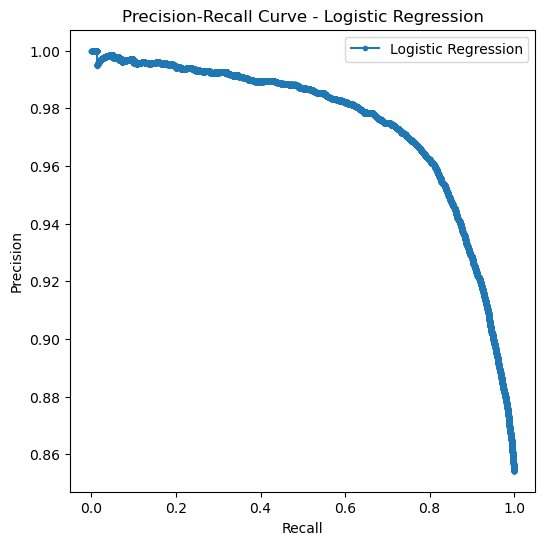

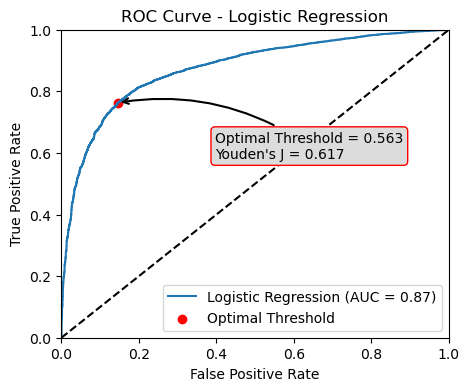

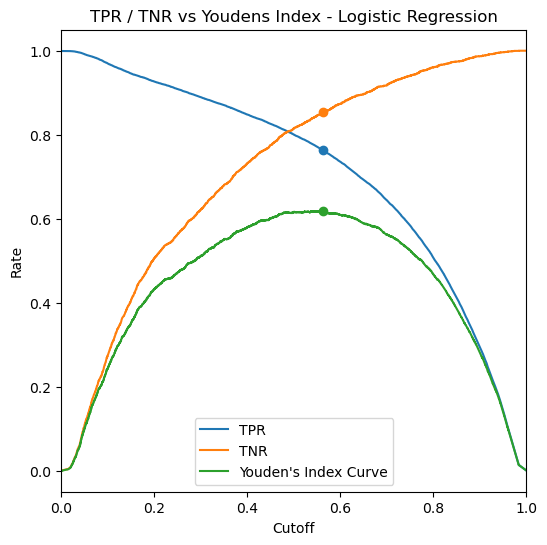

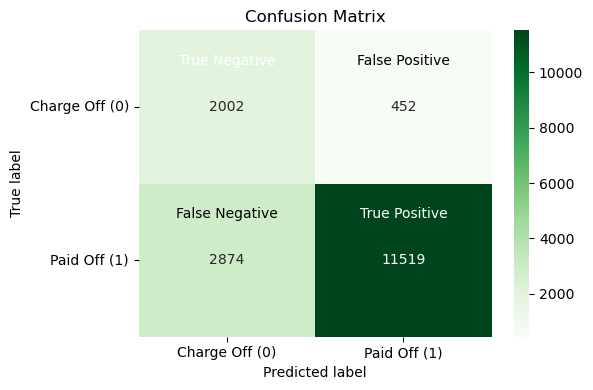

In [36]:
logreg_model_name, logreg_pr_curve_plot, logreg_roc_curve_plot, logreg_tpr_tnr_plot, logreg_conf_matrix, logreg_conf_matrix_plot, logreg_results = analyze_classification_model.analyze_model(logreg_trained_model,
                              'Logistic Regression',
                              class_names,
                              datasets,
                              "full")

model_pdf_report.save_model_results_to_pdf(logreg_model_name, logreg_pr_curve_plot, logreg_roc_curve_plot, logreg_tpr_tnr_plot, logreg_conf_matrix_plot, logreg_results, logreg_best_params)
results_frame = results_frame.append(logreg_results, ignore_index=True)

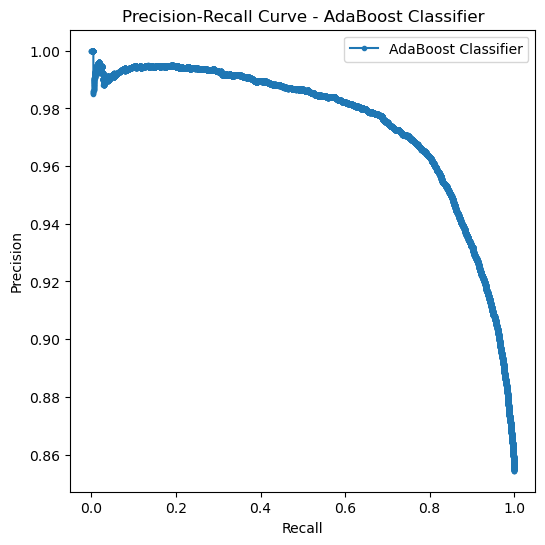

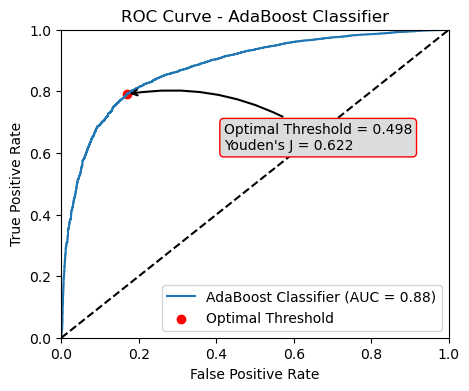

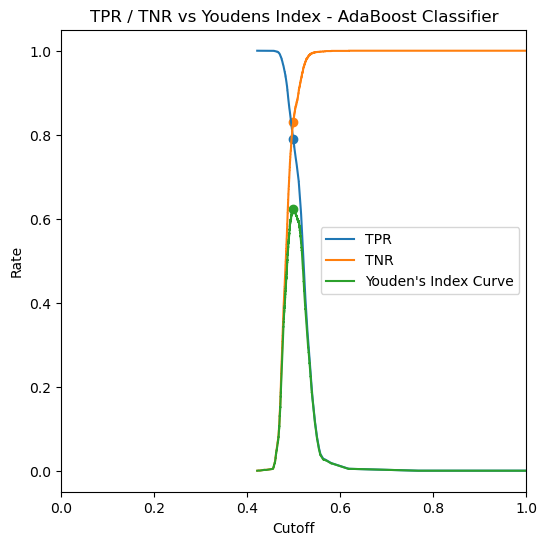

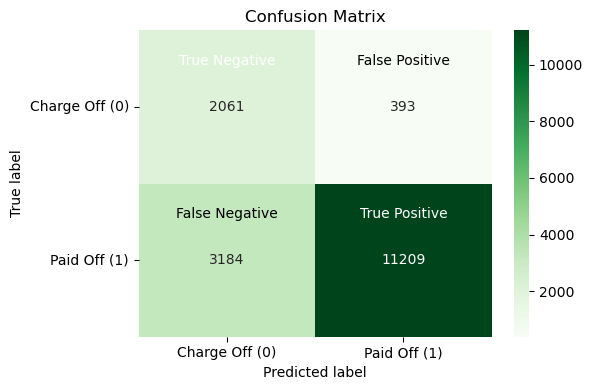

In [37]:
abc_model_name, abc_pr_curve_plot, abc_roc_curve_plot, abc_tpr_tnr_plot, abc_conf_matrix, abc_conf_matrix_plot, abc_results = analyze_classification_model.analyze_model(abc_trained_model,
                              'AdaBoost Classifier',
                              class_names,
                              datasets,
                              "full")

model_pdf_report.save_model_results_to_pdf(abc_model_name, abc_pr_curve_plot, abc_roc_curve_plot, abc_tpr_tnr_plot, abc_conf_matrix_plot, abc_results, abc_best_params)
results_frame = results_frame.append(abc_results, ignore_index=True)

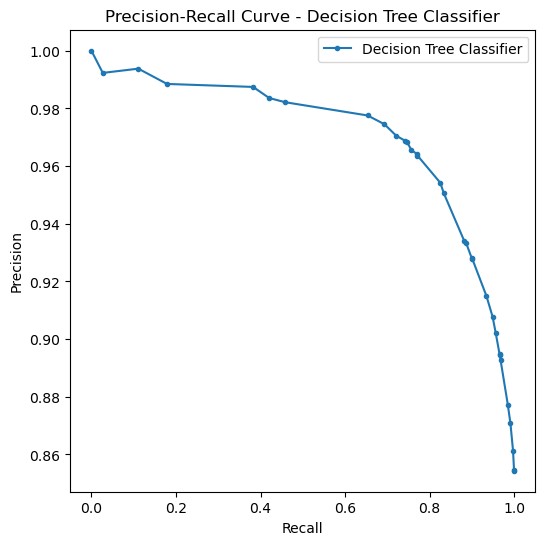

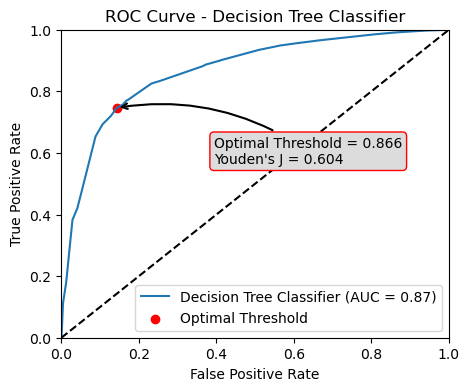

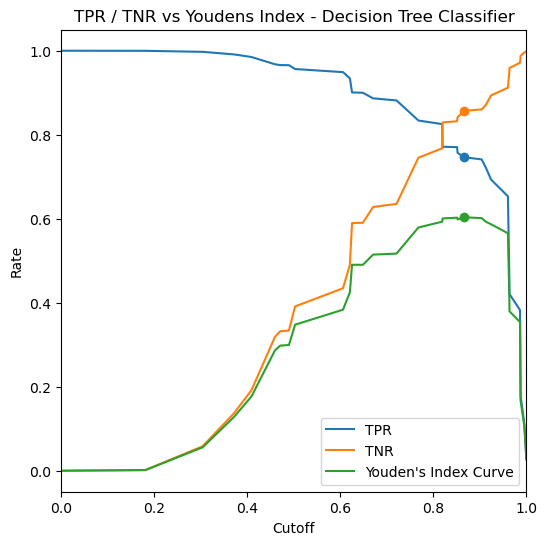

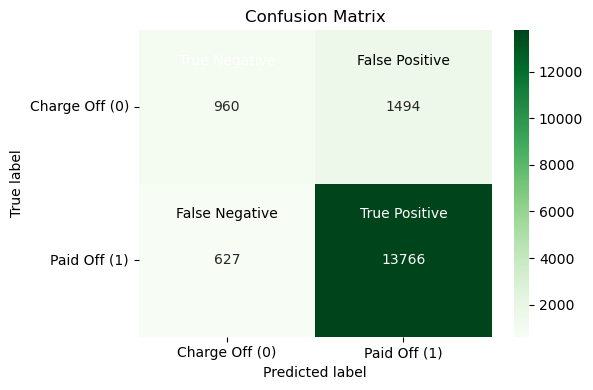

In [38]:
dt_model_name, dt_pr_curve_plot, dt_roc_curve_plot, dt_tpr_tnr_plot, dt_conf_matrix, dt_conf_matrix_plot, dt_results = analyze_classification_model.analyze_model(dt_trained_model,
                              'Decision Tree Classifier',
                              class_names,
                              datasets,
                              "full")

model_pdf_report.save_model_results_to_pdf(dt_model_name, dt_pr_curve_plot, dt_roc_curve_plot, dt_tpr_tnr_plot, dt_conf_matrix_plot, dt_results, dt_best_params)
results_frame = results_frame.append(dt_results, ignore_index=True)


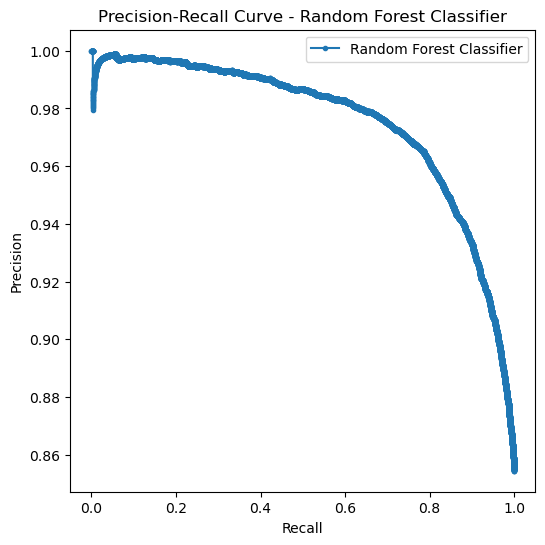

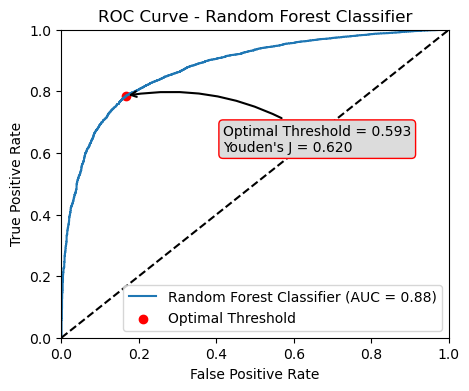

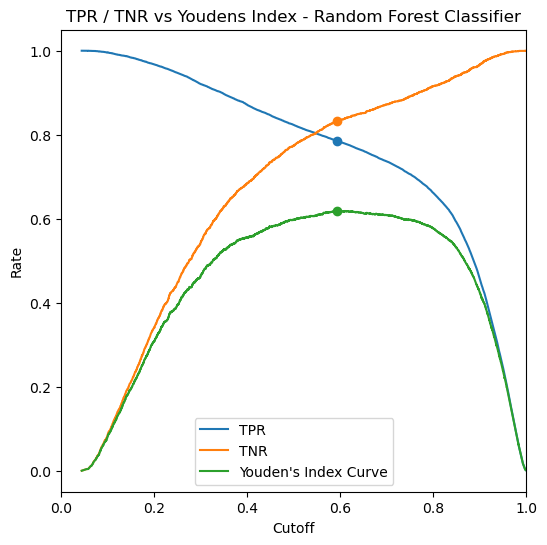

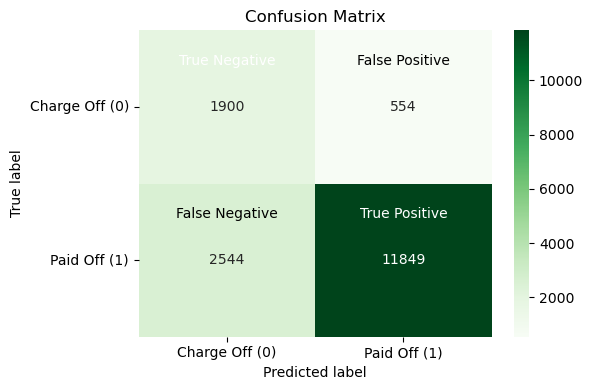

In [39]:
rfc_model_name, rfc_pr_curve_plot, rfc_roc_curve_plot, rfc_tpr_tnr_plot, rfc_conf_matrix, rfc_conf_matrix_plot, rfc_results = analyze_classification_model.analyze_model(rfc_trained_model,
                              'Random Forest Classifier',
                              class_names,
                              datasets,
                              "full")

model_pdf_report.save_model_results_to_pdf(rfc_model_name, rfc_pr_curve_plot, rfc_roc_curve_plot, rfc_tpr_tnr_plot, rfc_conf_matrix_plot, rfc_results, rfc_best_params)
results_frame = results_frame.append(rfc_results, ignore_index=True)

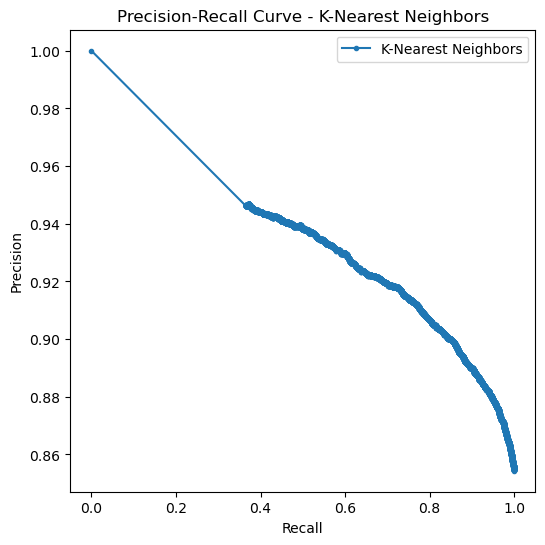

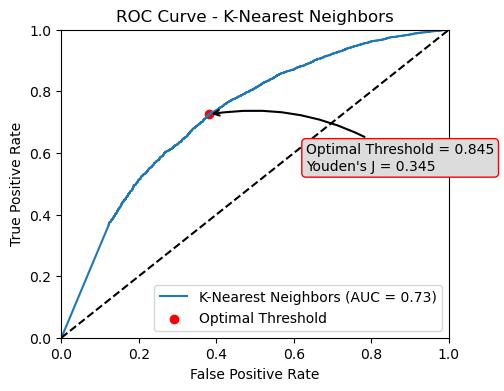

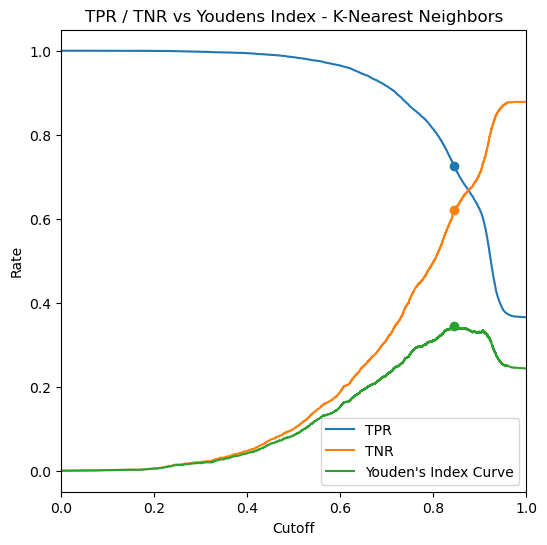

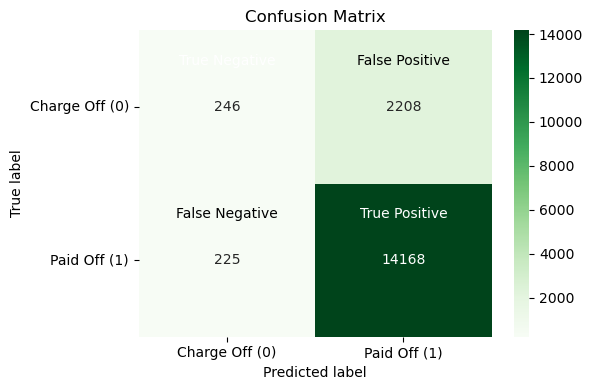

In [40]:
knn_model_name, knn_pr_curve_plot, knn_roc_curve_plot, knn_tpr_tnr_plot, knn_conf_matrix, knn_conf_matrix_plot, knn_results = analyze_classification_model.analyze_model(knn_trained_model,
                              'K-Nearest Neighbors',
                              class_names,
                              datasets,
                              "full")

model_pdf_report.save_model_results_to_pdf(knn_model_name, knn_pr_curve_plot, knn_roc_curve_plot, knn_tpr_tnr_plot, knn_conf_matrix_plot, knn_results, knn_best_params)
results_frame = results_frame.append(knn_results, ignore_index=True)

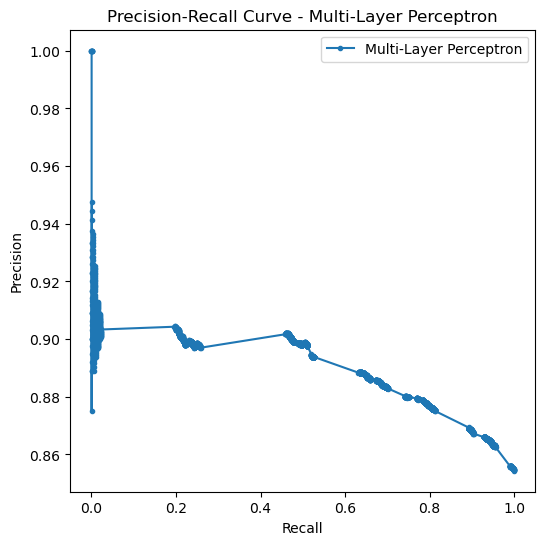

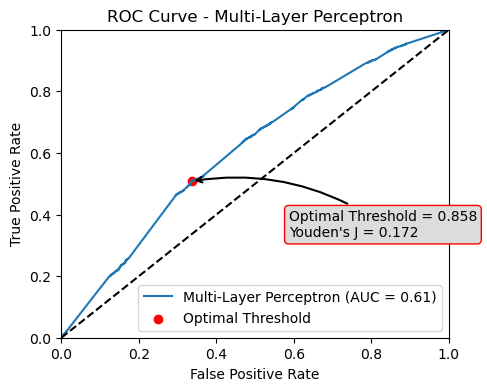

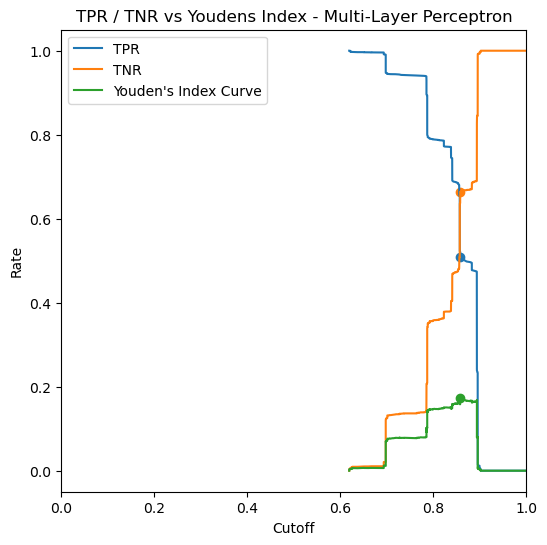

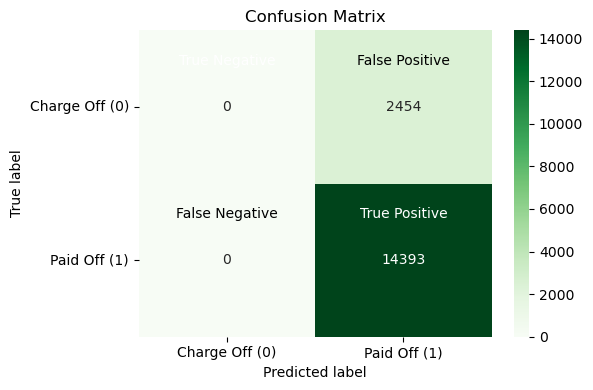

In [41]:
mlp_model_name, mlp_pr_curve_plot, mlp_roc_curve_plot, mlp_tpr_tnr_plot, mlp_conf_matrix, mlp_conf_matrix_plot, mlp_results = analyze_classification_model.analyze_model(mlp_trained_model,
                              'Multi-Layer Perceptron',
                              class_names,
                              datasets,
                              "Full")
def list_to_paragraph(value_list):
    style = getSampleStyleSheet()["BodyText"]
    return [Paragraph(str(value), style) for value in value_list]

results_frame = results_frame.append(mlp_results, ignore_index=True)

<h2> Section 6: Analysis Summary </h2>

In [42]:
results_frame

,Model Name,Confusion Matrix,Accuracy,Precision,Recall,Specificity,F1 Score,Youden J Stat,Optimal P Threshold
0,Logistic Regression,"[[2002, 452], [2874, 11519]]",0.802576,0.962242,0.800320,0.815811,0.873843,0.617403,0.562818
1,AdaBoost Classifier,"[[2061, 393], [3184, 11209]]",0.787677,0.966127,0.778781,0.839853,0.862397,0.621958,0.498417
2,Decision Tree Classifier,"[[960, 1494], [627, 13766]]",0.874102,0.902097,0.956437,0.391198,0.928473,0.603512,0.865613
3,Random Forest Classifier,"[[1900, 554], [2544, 11849]]",0.816110,0.955333,0.823247,0.774246,0.884386,0.619539,0.593091
4,K-Nearest Neighbors,"[[246, 2208], [225, 14168]]",0.855583,0.865169,0.984367,0.100244,0.920927,0.344740,0.844695
5,Multi-Layer Perceptron,"[[0, 2454], [0, 14393]]",0.854336,0.854336,1.000000,0.000000,0.921447,0.172316,0.857649


<h3> Conclusion </h3>

Based on the given model results, let's analyze the strengths and weaknesses of each model, check for overfitting, and determine the best model for this problem:
1.	Logistic Regression:
•	Strengths: Good accuracy (0.802576), high precision (0.962242), and a balanced trade-off between recall and specificity.
•	Weaknesses: Recall (0.800320) is relatively lower compared to some other models.
•	Overfitting: Not evident from the provided information.
•	Assessment: A good candidate for this problem but might not be the best.

2.	AdaBoost Classifier:
•	Strengths: High precision (0.966127) and specificity (0.839853).
•	Weaknesses: Lower accuracy (0.787677) and recall (0.778781) compared to other models.
•	Overfitting: Not evident from the provided information.
•	Assessment: Not the best choice due to lower accuracy and recall.

3.	Decision Tree Classifier:
•	Strengths: High recall (0.956437) and F1 score (0.928473).
•	Weaknesses: Low accuracy (0.874102), specificity (0.391198), and poor performance in identifying true negatives (high false positives).
•	Overfitting: Not evident from the provided information, but decision trees are prone to overfitting in general.
•	Assessment: Not suitable for this problem due to poor specificity.

4.	Random Forest Classifier:
•	Strengths: Good accuracy (0.816110) and high precision (0.955333).
•	Weaknesses: Lower recall (0.823247) compared to some other models.
•	Overfitting: Not evident from the provided information.
•	Assessment: A good candidate for this problem, but there might be better options.

5.	K-Nearest Neighbors:
•	Strengths: High recall (0.984367) and F1 score (0.920927).
•	Weaknesses: Poor accuracy (0.855583), low specificity (0.100244), and very high false positives.
•	Overfitting: Not evident from the provided information.
•	Assessment: Not suitable for this problem due to poor specificity.

6.	Multi-Layer Perceptron:
•	Strengths: High recall (1.000000) and F1 score (0.921447).
•	Weaknesses: Poor specificity (0.000000), meaning the model is unable to correctly identify any true negatives.
•	Overfitting: Not evident from the provided information, but neural networks can be prone to overfitting.
•	Assessment: Not suitable for this problem due to poor specificity.

Based on the assessment, the Logistic Regression model appears to be the best option, as it has a good balance between accuracy, precision, recall, and specificity. The Random Forest Classifier is also a good candidate, but its recall value is lower than that of the Logistic Regression model.

The underlying model seems to be useful and applicable, as it demonstrates the value of machine learning in the lending industry by accurately predicting the likelihood of default. This can help both lenders and borrowers make better financial decisions. However, it's important to consider other factors, such as the model's interpretability and the potential impact on fairness, before deploying it in a real-world setting.

